In [1]:
%%capture
from datetime import datetime
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import display
from sklearn import metrics
plt.rcParams.update({"font.size": 12})
%matplotlib inline

In [2]:
wsb_common_users_data = pd.read_csv("data/WSB_data_with_emb.csv",sep=';', usecols = ['title'], low_memory = True)
stocks_common_users_data= pd.read_csv("stocks/data/stocks_submissions_all.csv",sep=';', usecols = ['title'], low_memory = True)
investing_common_users_data= pd.read_csv("investing/data/investing_submissions_all.csv",sep=';', usecols = ['title'], low_memory = True)

In [3]:
# Create new column denoting class label and combine into one df
wsb_common_users_data['sub'] = 'wsb'
stocks_common_users_data['sub'] = 'stocks'
investing_common_users_data['sub'] = 'investing'

In [29]:
stocks_common_users_data.head(1)

,title,sub
0,SNAP seems like a great long-term buy at this ...,stocks


In [4]:
investing_common_users_data.head(1)

,title,sub
0,What do you use to invest?,investing


In [5]:
all_data = wsb_common_users_data.append(investing_common_users_data, ignore_index=True)

In [6]:
all_data = all_data.append(stocks_common_users_data, ignore_index=True)

In [7]:
all_data = all_data[pd.notnull(all_data['title'])]

In [8]:
all_data.head(1)

,title,sub
0,BB,wsb


In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144025 entries, 0 to 1144026
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   title   1144025 non-null  object
 1   sub     1144025 non-null  object
dtypes: object(2)
memory usage: 26.2+ MB


In [10]:
all_data['sub_id'] = all_data['sub'].factorize()[0]
category_id_df = all_data[['sub', 'sub_id']].drop_duplicates().sort_values('sub_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sub_id', 'sub']].values)
all_data.head()

,title,sub,sub_id
0,BB,wsb,0
1,Surely it is a coincidence.,wsb,0
2,yolo sava options,wsb,0
3,meme,wsb,0
4,BB,wsb,0


In [21]:
sample_data_1=all_data[all_data['sub']=='wsb'].sample(frac = 0.025)

In [22]:
sample_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21544 entries, 729628 to 256438
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   21544 non-null  object
 1   sub     21544 non-null  object
 2   sub_id  21544 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 673.2+ KB


In [25]:
sample_data_2=all_data[all_data['sub']=='stocks'].sample(frac = 0.15)

In [26]:
sample_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23176 entries, 994627 to 1110244
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23176 non-null  object
 1   sub     23176 non-null  object
 2   sub_id  23176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 724.2+ KB


In [27]:
sample_data_3=all_data[all_data['sub']=='investing'].sample(frac = 0.15)

In [28]:
sample_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23176 entries, 994627 to 1110244
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23176 non-null  object
 1   sub     23176 non-null  object
 2   sub_id  23176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 724.2+ KB


In [30]:
sample_data = sample_data_1.append(sample_data_2, ignore_index=True)
sample_data = sample_data.append(sample_data_3, ignore_index=True)
sample_data = sample_data[pd.notnull(sample_data['title'])]

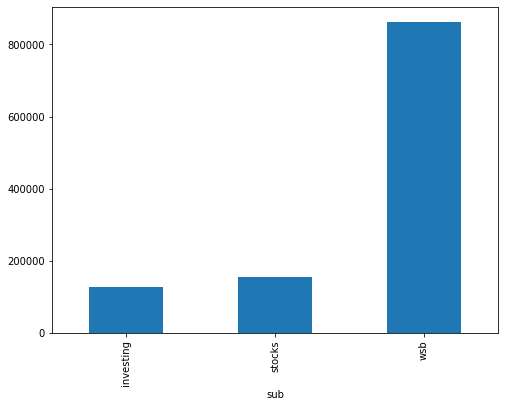

In [31]:
fig = plt.figure(figsize=(8,6))
all_data.groupby('sub').title.count().plot.bar(ylim=0)
plt.show()

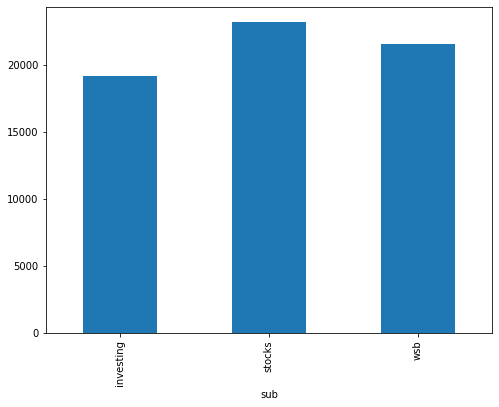

In [32]:
fig = plt.figure(figsize=(8,6))
sample_data.groupby('sub').title.count().plot.bar(ylim=0)
plt.show()

In [33]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 1), stop_words='english',token_pattern=r'[^\s]+')
features = tfidf.fit_transform(sample_data.title).toarray() #+all_data.selftext
labels = sample_data.sub_id
features.shape

(63885, 8243)

In [35]:
N = 15
for Product, category_id in sorted(category_to_id.items()):
   # X{array-like, sparse matrix} of shape (n_samples, n_features)
    #y -array-like of shape (n_samples,)
    #Target vector (class labels).
  features_chi2 = chi2(features, labels == category_id) 

  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
 

# 'investing':
  . Most correlated unigrams:
. bond
. basic
. bonds
. fund
. moon
. 401k
. index
. amc
. questions
. gme
. ira
. invest
. roth
. investment
. investing
# 'stocks':
  . Most correlated unigrams:
. apes
. $gme
. fuck
. 🚀🚀🚀
. question
. 🚀
. wsb
. moon
. yolo
. r/stocks
. stocks?
. gme
. stock
. thoughts
. stocks
# 'wsb':
  . Most correlated unigrams:
. wsb
. invest
. apes
. hold
. stock
. thoughts
. fuck
. 🚀🚀🚀
. 🚀
. yolo
. amc
. investing
. stocks
. moon
. gme


In [36]:
X_train, X_test, y_train, y_test = train_test_split(sample_data['title'], sample_data['sub'], random_state = 0)
count_vect = CountVectorizer(token_pattern=r'[^\s]+')#analyzer = 'char', binary = True)
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [37]:
print(clf.predict(count_vect.transform(["🦍"])))

['wsb']


In [38]:
print(clf.predict(count_vect.transform(["🚀"])))

['wsb']


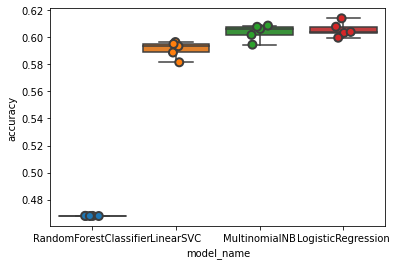

In [30]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0,max_iter=3000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [31]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.591137
LogisticRegression        0.605846
MultinomialNB             0.603882
RandomForestClassifier    0.467866
Name: accuracy, dtype: float64

In [32]:
category_id_df['sub'].values

array(['wsb', 'investing', 'stocks'], dtype=object)

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


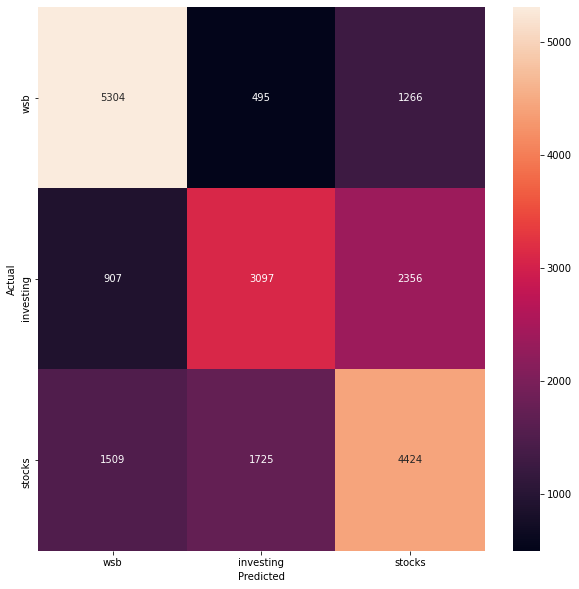

In [39]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, sample_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['sub'].values, yticklabels=category_id_df['sub'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [40]:
category_id_df

,sub,sub_id
0,wsb,0
861752,investing,1
989521,stocks,2


In [41]:
from IPython.display import display
for predicted in category_id_df.sub_id:
  for actual in category_id_df.sub_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(sample_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['sub', 'title']])
      print('')

'investing' predicted as 'wsb' : 907 examples.


,sub,title
45041,investing,What do people mean when they say “Follow the ...
46294,investing,"Will ""Litepay"" bring cryptocurrencies out of t..."
54536,investing,$NIO (2/28) Put Options?
49636,investing,Everyone buy 1 share of GME🚀🚀
58714,investing,"SUP BOYS, I'M HERE FOR THE SICK 4-5% CAGR!!!"
...,...,...
46513,investing,How Dogecoin is a sh*tcoin :D
52093,investing,Any support or offer is welcome
54336,investing,What Can Inflate ROE/ROA
57822,investing,I'm curious



'stocks' predicted as 'wsb' : 1509 examples.


,sub,title
37284,stocks,Woah
23900,stocks,"Sold most of my $GME shares at a gain, kept 5 ..."
36689,stocks,Are we banned from talking about GNUS?
26779,stocks,$MGNX INSANITY up 231.45% TODAY
26382,stocks,¿Why isn’t there a sub dedicated to Michael Bu...
...,...,...
25497,stocks,Please 😉would be nice let's go
32931,stocks,Slanaz SLC waves
36022,stocks,A Human Declaration
35198,stocks,100 shares of $SPCE $29 call expiring today. I...



'wsb' predicted as 'investing' : 495 examples.


,sub,title
14865,wsb,the FUTURE
3913,wsb,Thinking the young retail investors are irresp...
14968,wsb,Zuckerberg &amp; Gates - Spending their money ...
14501,wsb,Bad things happen to Margin Accounts when the ...
19178,wsb,04/01/2020 I decided to change my 401(k) to se...
...,...,...
7869,wsb,There is a short happening... of gas
10005,wsb,Current situation simplified...
14468,wsb,GME execs being congratulated for the company ...
6173,wsb,perspective



'stocks' predicted as 'investing' : 1725 examples.


,sub,title
40856,stocks,switching brokerage
30481,stocks,Tech Heavy
28372,stocks,National Beverage Corporation (FIZZ) seems rea...
36853,stocks,Auto allocation
23731,stocks,"With strikes and a ‘sick out,’ some grocery an..."
...,...,...
28707,stocks,Bitcoin is multiplying as right now
36715,stocks,Fidelity Contrafund questions
33371,stocks,cash account restriction/ account transfer?
34334,stocks,"TOBACCO INDUSTRY (PM, MO, BAT)"



'wsb' predicted as 'stocks' : 1266 examples.


,sub,title
17588,wsb,Newbie looking for advice.
12172,wsb,my curent DD
4126,wsb,"NFTs...Playboy, Topps...who got next? Blockcha..."
19251,wsb,NVDA FDs?
20682,wsb,Keep HODLING and buying! Topping the most trad...
...,...,...
12016,wsb,Tesla earning here I come 🔥🚗
18749,wsb,i have like 8 companies on the verge of curing...
16835,wsb,Short Term Bullish
4003,wsb,NWBO has a huge short position by Adam FEUERST...



'investing' predicted as 'stocks' : 2356 examples.


,sub,title
62351,investing,Tesla likely to miss record second-quarter del...
62453,investing,Reddit filing for an IPO in future say sources
47134,investing,Best way to capitalize on raising Uranium
45633,investing,"who to pick out of msft, aapl, googl, amzn, nflx?"
56056,investing,Best stocks for 2021 to invest in
...,...,...
46446,investing,ARK dividends
60140,investing,How does after- hours trading work??
60193,investing,Thoughts on these Data Point for Excel Spreads...
55229,investing,What’s the perfect ETF portfolio for a 37 year...


In [42]:
model.fit(features, labels)


C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [43]:
N = 10
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]

  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  

# 'investing':
  . Top unigrams:
       . investing
       . spitballin
       . bonds
       . 401k
       . investment
       . estate
       . bitcoin
       . investing?
       . bond
       . investments?
# 'stocks':
  . Top unigrams:
       . r/stocks
       . stocks
       . dkng
       . stocks?
       . gnus
       . mojo
       . tradingview
       . mgm
       . stock
       . rtx
# 'wsb':
  . Top unigrams:
       . yolo
       . retards
       . tendies
       . retard
       . fucking
       . apes
       . melvin
       . 🌈🐻
       . ape
       . retarded


In [44]:
print(metrics.classification_report(y_test, y_pred, target_names=sample_data['sub'].unique()))

              precision    recall  f1-score   support

         wsb       0.69      0.75      0.72      7065
      stocks       0.58      0.49      0.53      6360
   investing       0.55      0.58      0.56      7658

    accuracy                           0.61     21083
   macro avg       0.61      0.61      0.60     21083
weighted avg       0.61      0.61      0.61     21083



# 'investing':
(0, ('r/stocks', -2.323351808043773))
(1, ('ape', -1.9413956573533058))
(2, ('amc', -1.9325681369640695))
(3, ('fucking', -1.9030718682754575))
(4, ('melvin', -1.8614491281765724))
(5, ('retards', -1.8072057781487927))
(6, ('stonks', -1.7867170268859125))
(7, ('apes', -1.7857080701097081))
(8, ('retard', -1.744907562207206))
(9, ('bb', -1.7194882026666338))
(10, ('wkhs', -1.6207122935505271))
(11, ('$amc', -1.6174493183902665))
(12, ('yolo', -1.5262640462601702))
(13, ('🚀🚀', -1.501196852880103))
(14, ('🚀🚀🚀🚀', -1.4763638945128164))
(15, ('gme.', -1.4616570159569353))
(16, ('autist', -1.4390325926862548))
(17, ('clov', -1.4020356480860139))
(18, ('porn', -1.3620676823642108))
(19, ('hands', -1.3587041451433184))
(20, ('tendies', -1.3459147335382042))
(21, ('gme', -1.3431294370338038))
(22, ('$bb', -1.341285542400938))
(23, ('boys', -1.3336140679425343))
(24, ('revolut', -1.3200878035704888))


C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0, flags=flags)


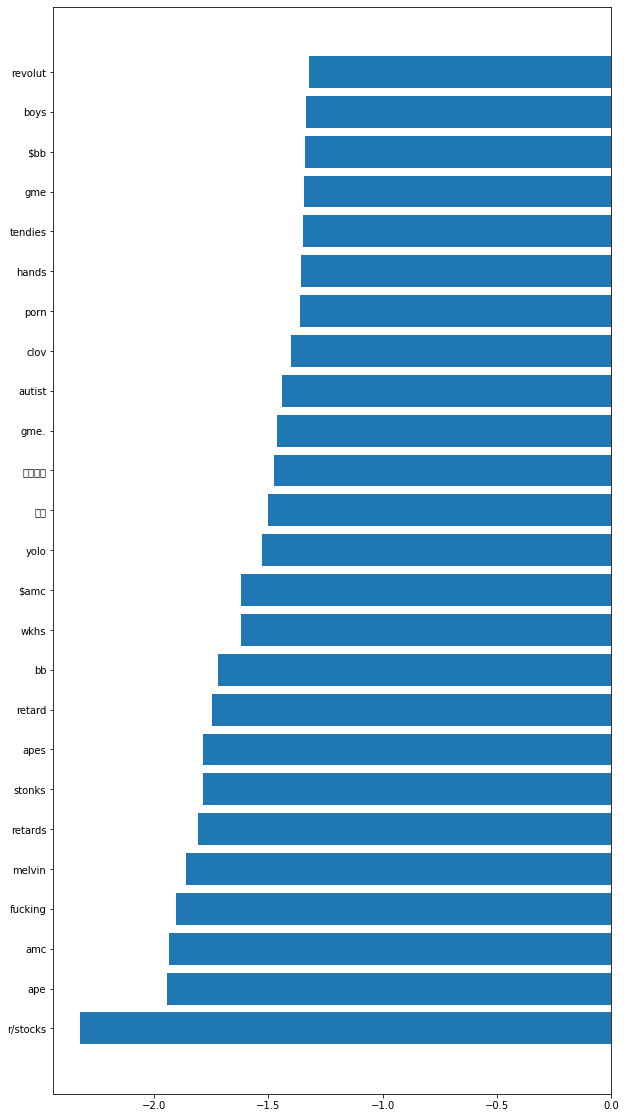

# 'stocks':
(0, ('yolo', -2.215422467082583))
(1, ('tendies', -2.141733393383097))
(2, ('thread', -1.9948079610909935))
(3, ('retards', -1.8568286326084822))
(4, ('gains.', -1.7150050971909272))
(5, ('$gme', -1.7123408811824492))
(6, ('retard', -1.6757190369272932))
(7, ('💎', -1.5836321415742223))
(8, ('wsb', -1.5698888534782265))
(9, ('posted', -1.5679145469469429))
(10, ('🌈🐻', -1.5664557685336906))
(11, ('retarded', -1.5543388351131926))
(12, ('gang', -1.5457571478860934))
(13, ('💎🙌', -1.513041186284583))
(14, ('autists', -1.4837141682830022))
(15, ('token', -1.482329413324709))
(16, ('spitballin', -1.4465279185665731))
(17, ('history', -1.4443936688251664))
(18, ('thread.', -1.4260889393788645))
(19, ('friends', -1.3999926515904522))
(20, ('hodl', -1.3835330479676364))
(21, ('ig', -1.3776916733903721))
(22, ('allowing', -1.3667629239235772))
(23, ('virtual', -1.3573334407047064))
(24, ('shut', -1.3554946129838628))


C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128059 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0, flags=flags)
C:

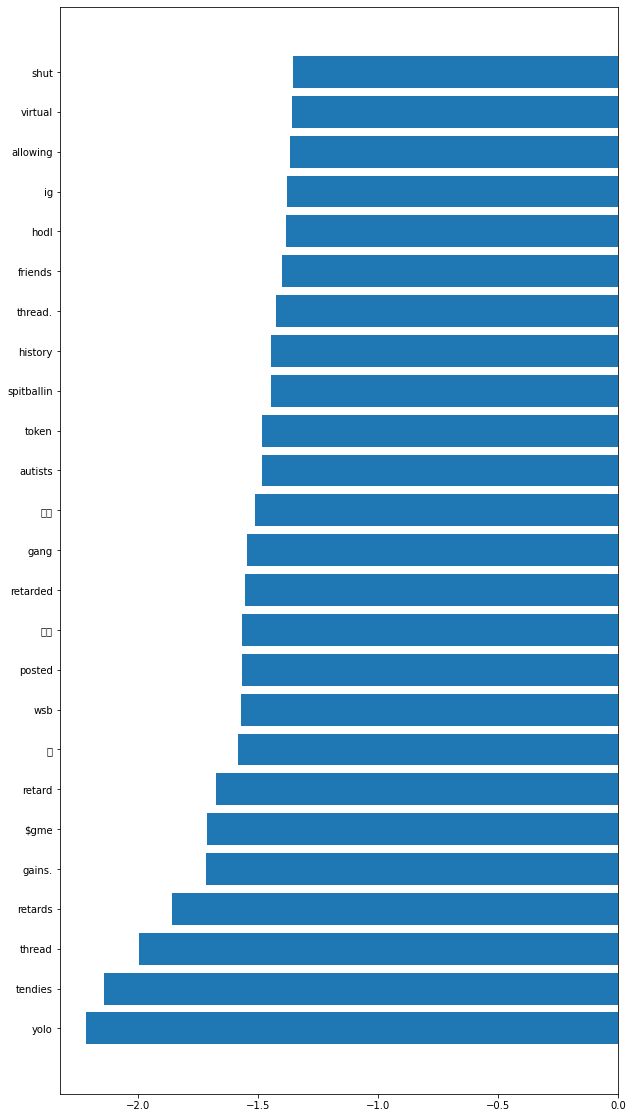

# 'wsb':
(0, ('investing', -3.444772777845908))
(1, ('etfs', -2.967270748614393))
(2, ('stocks', -2.9547536909279604))
(3, ('stocks?', -2.8024917586491505))
(4, ('questions', -2.692153779236689))
(5, ('etf', -2.670228493892468))
(6, ('r/stocks', -2.6113101991987504))
(7, ('bitcoin', -2.534368932582786))
(8, ('investing?', -2.5291197320342422))
(9, ('investment', -2.4874021279876515))
(10, ('invest', -2.4823041421514693))
(11, ('question', -2.4170608720938778))
(12, ('dividend', -2.336019800284364))
(13, ('years?', -2.247119141987114))
(14, ('portfolio?', -2.1284467292721865))
(15, ('companies', -2.0866588958441983))
(16, ('thoughts', -2.074856117382636))
(17, ('income', -2.0624481210575203))
(18, ('roth', -2.0102377588092293))
(19, ('term', -1.9902546057043589))
(20, ('wash', -1.9560957838221393))
(21, ('investments?', -1.9044472455077368))
(22, ('crypto', -1.904226974384591))
(23, ('index', -1.859939245656627))
(24, ('portfolio', -1.8293938700740136))


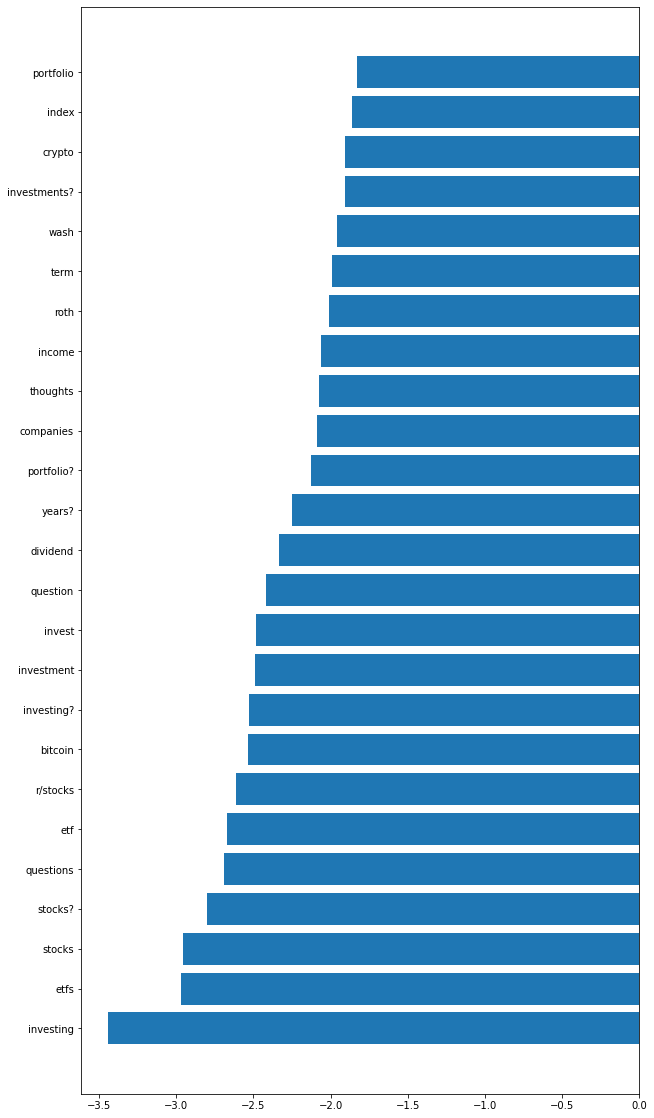

In [45]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[:25],importance[:25])):
        print((i,v))
    # plot feature importance
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[:25], importance[:25])    
    pyplot.show()

# 'investing':
(0, ('vanguard', 1.496949547527376))
(1, ('moronic', 1.4986188589385419))
(2, ('etfs?', 1.4992910832600974))
(3, ('economic', 1.5073629937250852))
(4, ('rollover', 1.507592518881689))
(5, ('crypto?', 1.5092493148664126))
(6, ('capital', 1.510306633409511))
(7, ('rates?', 1.511698170215295))
(8, ('insight', 1.514767470495605))
(9, ('earn', 1.5234282920986084))
(10, ('employer', 1.5385114669015616))
(11, ('bonus', 1.539735763486946))
(12, ('impact', 1.5404314180274588))
(13, ('loans', 1.5420998418880532))
(14, ('eli5:', 1.5650982104102744))
(15, ('hedging', 1.5707570790605458))
(16, ('robo', 1.580261414838484))
(17, ('staking', 1.5824519479859487))
(18, ('mutual', 1.5854158780272218))
(19, ('ira', 1.5908696924350376))
(20, ('lending', 1.5925725922955571))
(21, ('etfs', 1.5989560318855556))
(22, ('cryptocurrencies', 1.6299420041268862))
(23, ('index', 1.6511698094834246))
(24, ('rates', 1.689450667446394))
(25, ('years?', 1.7051555667220428))
(26, ('asset', 1.70568106625052

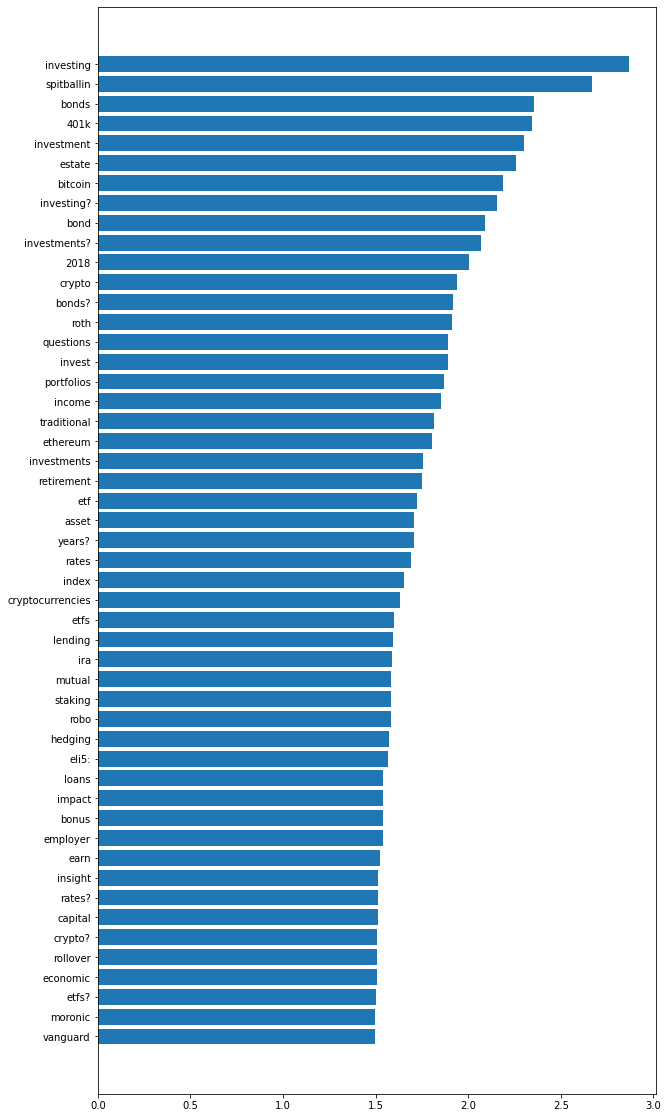

# 'stocks':
(0, ('beginner', 1.2088874848349398))
(1, ('li', 1.217363215279753))
(2, ('merge', 1.2240215352725472))
(3, ('ipos', 1.226774961450235))
(4, ('mistake?', 1.2314183078471075))
(5, ('question', 1.2374323564549428))
(6, ('stock/etf', 1.2408554030687577))
(7, ('institutions', 1.24199617419843))
(8, ('kinda', 1.2433670188715533))
(9, ('cloudflare', 1.246585014691324))
(10, ('tsla?', 1.261468625963283))
(11, ('baba', 1.264085155568515))
(12, ('term?', 1.2757275588999437))
(13, ('year,', 1.2938000026124015))
(14, ('p/e', 1.2948597193762508))
(15, ('ino', 1.3022732822558327))
(16, ('gift', 1.3038725787184584))
(17, ("etf's?", 1.3105309881144256))
(18, ('ticker:', 1.3178137691088558))
(19, ('tesla,', 1.3251470257965752))
(20, ('recap', 1.3308177001158452))
(21, ('movers', 1.3309620130885393))
(22, ('stock?', 1.3314923600449255))
(23, ('be?', 1.33346042947398))
(24, ('trade?', 1.3363551205967632))
(25, ('rookie', 1.340632920020074))
(26, ('wkhs?', 1.3470233262004232))
(27, ('hcmc', 1

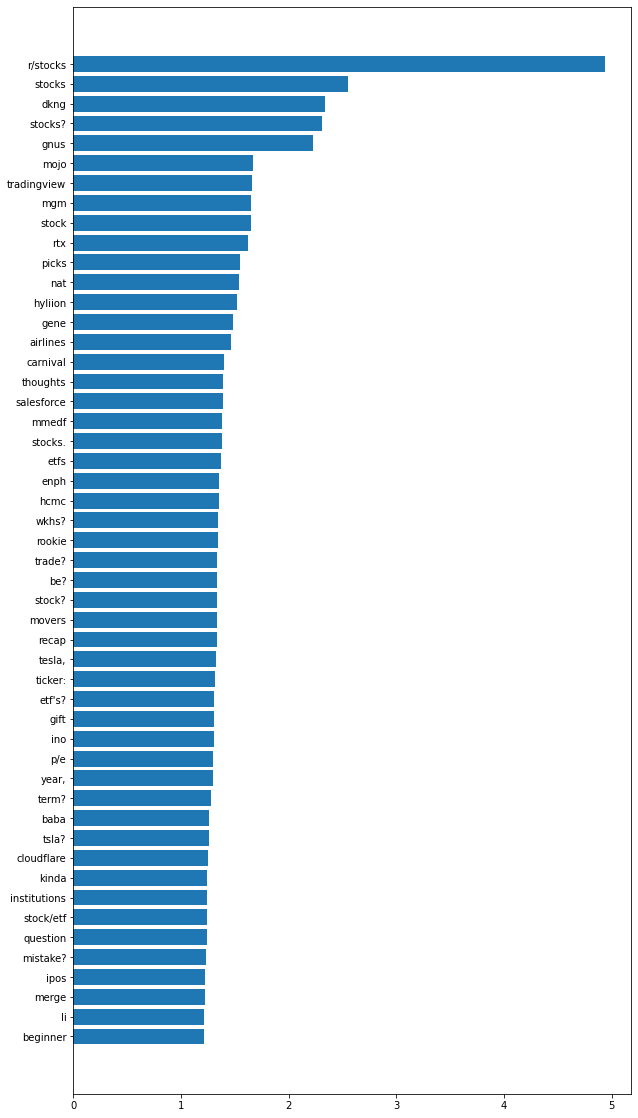

# 'wsb':
(0, ('amc', 1.7685998673660308))
(1, ('blocking', 1.7723190136532114))
(2, ('i’ll', 1.7746698286529659))
(3, ('retards.', 1.7776271058698703))
(4, ('🦍', 1.7802563064889123))
(5, ('🚀🚀🚀🚀🚀', 1.7900337571019003))
(6, ('😎', 1.7936381013795757))
(7, ('🐻', 1.795333479071528))
(8, ('spotted', 1.8072198336030176))
(9, ('fucked', 1.84468673575234))
(10, ('ain’t', 1.8473769980888937))
(11, ('stonk', 1.8548846509897727))
(12, ('bb', 1.8587905991435776))
(13, ('🚀🚀', 1.8854310306961857))
(14, ('autistic', 1.9265412867853586))
(15, ('autism', 1.929993239516409))
(16, ('hedgies', 1.9395985163127192))
(17, ('likes', 1.9444748909680714))
(18, ('diamond', 1.955926899740036))
(19, ('clov', 1.9654691587670947))
(20, ('dfv', 1.9793082984983181))
(21, ('wsb', 1.9821581404081083))
(22, ('💎', 1.9934160142741357))
(23, ('shit', 2.0087971471493486))
(24, ('🚀', 2.0121366013268815))
(25, ('420', 2.0617127897250165))
(26, ('boys', 2.0651985558434895))
(27, ('hands', 2.076097998278062))
(28, ('gme', 2.09473

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 129421 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 129421 missing from current font.
  font.set_text(s, 0, flags=flags)


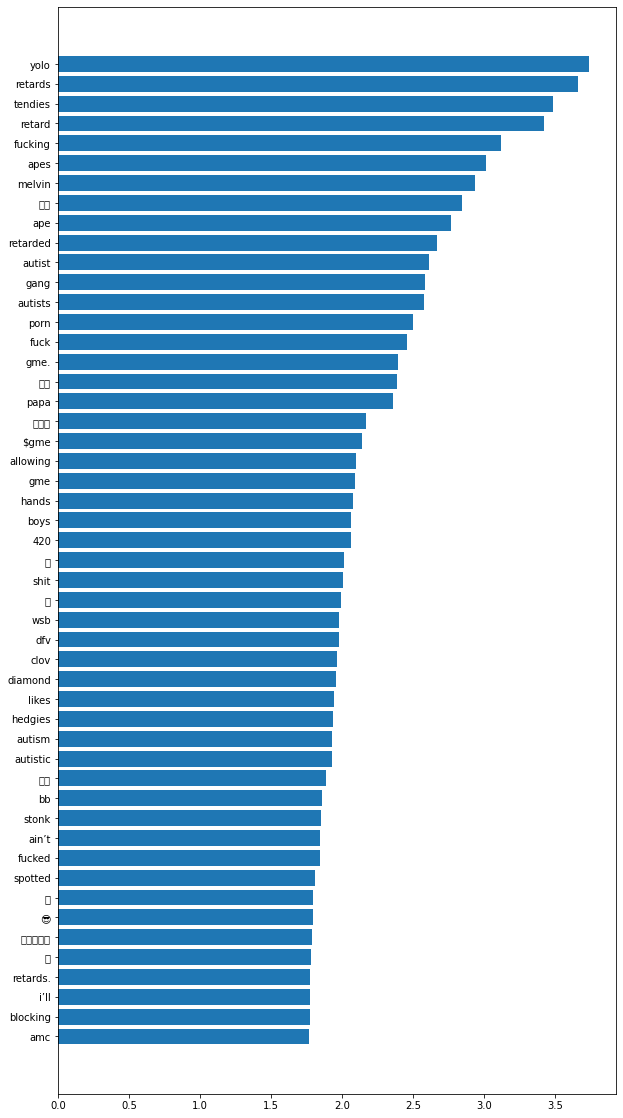

In [46]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[(len(feature_names[:])-50):],importance[(len(feature_names[:])-50):])):
        print((i,v))
    # plot feature importance
    #pyplot.bar([x for x in range(len(importance[:10]))], importance[:10])
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[len(feature_names[:])-50:], importance[len(feature_names[:])-50:])    
    pyplot.show()